In [1]:
from Phi import *
import torch
import math
from torch import nn, optim
import torch.nn.functional as F
from torchdiffeq import odeint, odeint_adjoint
from utils.ToyModels import *
import matplotlib.pyplot as plt

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

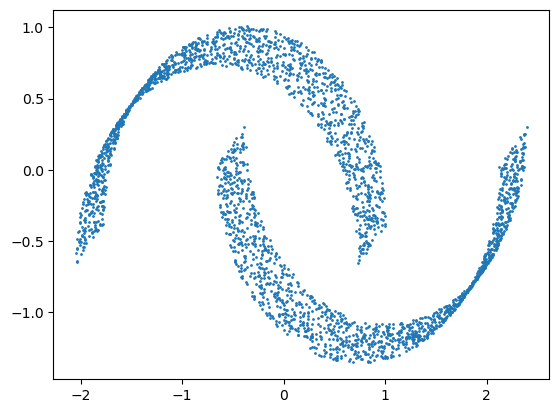

In [3]:
plt.scatter(*generate_moon_data(n_samples=3001, noise=2e-1)[0].T, s=1.)

In [4]:
class OdeFunc(nn.Module):
    def __init__(self, d: int, m:int, nTh: int):
        super(OdeFunc, self).__init__()
        self.d = d
        self.m = m
        self.nTh = nTh
        self.net = Phi(self.nTh, self.m, self.d)
    
    def forward(self, t, x):
        x = x[:, :self.d]
        # z = F.pad(x,[0,1,0,0],  value=t)
        z = torch.cat((x, t*torch.ones(x.shape[0],1).to(device)), 1)
        gradPhi, trH = self.net.trHess(z)
        dx = - gradPhi[:,:self.d]
        dl = - trH.unsqueeze(1)
        dv = 0.5 * torch.sum(torch.pow(dx, 2), 1, keepdim=True)
        dr = torch.abs(-gradPhi[:,-1].unsqueeze(1) +  dv)
        return torch.cat((dx, dl, dv, dr), 1)

In [5]:
# def C(z):
#     """Expected negative log-likelihood; see Eq.(3) in the paper"""
#     d = z.shape[1]-3
#     l = z[:,d] # log-det

#     return -( torch.sum(  -0.5 * math.log(2*math.pi) - torch.pow(z[:,0:d],2) / 2  , 1 , keepdims=True ) + l.unsqueeze(1) )


def compute_loss(x: torch.Tensor):
    d = x.shape[1] - 3
    C = 1/2 * torch.sum(torch.pow(x[:, :d], 2), dim=1) - x[:, -3] + torch.log(torch.tensor([2]) * torch.pi).to(device)
    L = torch.mean(x[:,-2])
    R = torch.mean(x[:,-1])
    return torch.mean(C) + L + R

In [6]:
d = 2
m = 32
OTFlow = OdeFunc(d,m, 2).to(device)

In [7]:
def get_batch(n_smple):
    x, _ = generate_moon_data(n_samples=n_smple, noise=2e-1)
    return x

In [11]:
# get_batch(10)

tensor([[ 0.9646, -0.3715],
        [ 0.3439,  0.3439],
        [-0.6030,  0.7331],
        [-1.5724,  0.3171],
        [-1.7400, -0.4039],
        [-0.4389,  0.2292],
        [-0.0390, -0.7071],
        [ 0.8840, -1.1201],
        [ 1.7420, -0.8155],
        [ 2.1288,  0.1247]])

In [8]:

optimizer = optim.Adam(OTFlow.parameters(), lr=1e-3)
t0 = 0
t1 = 1

In [21]:

for _ in range(4000):
    optimizer.zero_grad()
    x = get_batch(12000).to(device)
    x = F.pad(x,[0,3,0,0],  value=0).to(device)
    t = torch.tensor([t0,t1], dtype=torch.float32) .to(device)
    x0 = odeint(OTFlow, x, t, 
                method='dopri5',
                rtol=1e-5,
                atol=1e-5).to(device)
    loss = compute_loss(x0[-1])
    loss.backward()
    optimizer.step()

    print(loss.item())


    

1.6018613576889038
1.5526325702667236
1.5957130193710327
1.558990240097046
1.561559796333313
1.5423002243041992
1.55430006980896
1.542788028717041
1.5480625629425049
1.5414592027664185
1.5384570360183716
1.5556564331054688
1.548986554145813
1.5423293113708496
1.5447750091552734
1.5370025634765625
1.5415549278259277
1.5338711738586426
1.53776216506958
1.5362383127212524
1.5365402698516846
1.5360438823699951
1.5369584560394287
1.5352016687393188
1.534503698348999
1.5358469486236572
1.5328832864761353
1.5369840860366821
1.5340466499328613
1.5382534265518188
1.5403223037719727
1.5355545282363892
1.5378899574279785
1.5513341426849365
1.5624535083770752
1.5579032897949219
1.5527383089065552
1.5563148260116577
1.5563820600509644
1.560845136642456
1.5341591835021973
1.544321060180664
1.5432337522506714
1.5426450967788696
1.5390877723693848
1.5426805019378662
1.53878653049469
1.546785831451416
1.530796766281128
1.5601894855499268
1.560012698173523
1.5708191394805908
1.5426164865493774
1.5626168

In [7]:
# torch.save(
#     {
#         'itr': 300,
#         'model_state_dict': OTFlow.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': loss.item(),
#     },
#     'OTFlow.pth'
# )

NameError: name 'OTFlow' is not defined

In [41]:
checkpoint = torch.load('OTFlow.pth')
OTFlow.load_state_dict(checkpoint["model_state_dict"])
OTFlow.eval()
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

RuntimeError: Error(s) in loading state_dict for OdeFunc:
	size mismatch for net.w.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 32]).
	size mismatch for net.N.layers.0.weight: copying a param with shape torch.Size([64, 3]) from checkpoint, the shape in current model is torch.Size([32, 3]).
	size mismatch for net.N.layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for net.N.layers.1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for net.N.layers.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).

300

In [16]:
p_z0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]).to(device),
    covariance_matrix=torch.tensor([[1, 0.0], [0.0, 1]]).to(device)
)
z0 = p_z0.sample((1000,)).to(device)



In [17]:

with torch.no_grad():
    x1 = odeint(OTFlow, F.pad(z0, [0,3,0,0], value=0), torch.tensor([t1,t0], dtype=torch.float).to(device), method='dopri5').to(device)

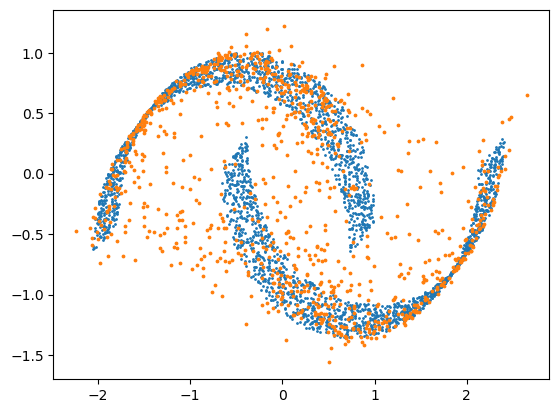

In [20]:

plt.scatter(*generate_moon_data(n_samples=3001, noise=2e-1)[0].T, s=1.)
plt.scatter(*x1[-1][:,0:2].detach().cpu().T, s=3)

In [ ]:
torch.randn(2,5)[:,]

tensor([[-0.7578, -1.1828, -1.6347, -0.8153, -0.7638],
        [-0.0907, -0.5955, -0.8134, -0.1275, -0.1994]])